<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/19oWnb5CxC5g-Zn45VWjuq_OP8YPCrn_g8Wq3aMaW2U4).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:
'''
1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING
''';

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [5]:
y_train[0]

5

In [6]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test ), axis=0)

Определим число уникальных значений меток целевого класса.

In [7]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

In [79]:
states = {1: 'ходьбе', 2: 'подъему вверх по лестнице', 3: 'спуску по лестнице', 4: 'сидению', 5: 'стоянию', 6: 'лежанию'}

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [9]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

65 0.9004833346822928


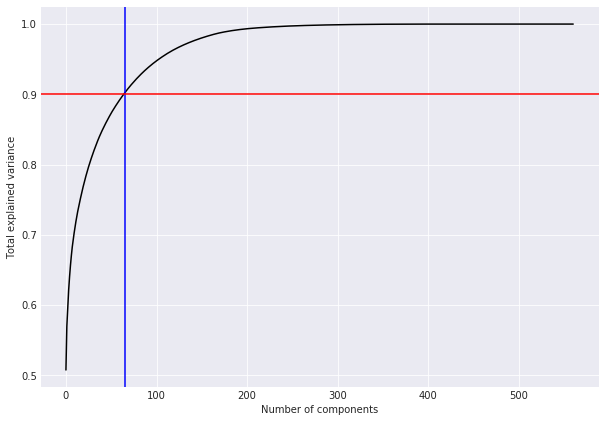

In [38]:
pca = PCA(random_state=RANDOM_STATE).fit(X_scaled)
need_percentage = 0.9
cunsum = np.cumsum(pca.explained_variance_ratio_)
count_components, left_variance = [
    (count_index + 1, value) for count_index, value in enumerate(cunsum)
    if value > need_percentage
][0]
print(count_components, left_variance)

plt.figure(figsize=(10,7))
plt.plot(cunsum, color='k',)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.axvline(count_components, c='b')
plt.axhline(need_percentage, c='r')
plt.show();

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56 
- 65
- 66
- 193

### Ответ: 65

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [51]:
pca = PCA(n_components=count_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [53]:
round(pca.explained_variance_ratio_[0], 2)

0.51

### Ответ: 51

Визуализируйте данные в проекции на первые две главные компоненты.

In [60]:
len(X_scaled[0])

561

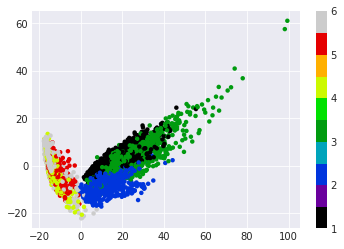

In [78]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_reduced = pca.fit_transform(X_scaled)

# cmap='viridis',
plt.scatter(
    X_reduced[:,0], X_reduced[:,1], 
    c=y, s=20,  label=y, edgecolor='none', 
#     cmap='viridis',
    cmap=plt.cm.get_cmap('nipy_spectral', 10),
);
plt.colorbar();

In [81]:
print(states[4], states[5], states[6])
print(states[1], states[2], states[3])

сидению стоянию лежанию
ходьбе подъему вверх по лестнице спуску по лестнице


**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

### Ответ: 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [84]:
kmeans = KMeans(n_init=100, n_clusters=len(np.unique(y)), random_state=RANDOM_STATE).fit(X_pca)

In [98]:
cluster_labels = kmeans.predict(X_pca)

In [99]:
# т.к. в y статусы идут с 1, а в y_predicted - статусы идут с 0
print(cluster_labels[0], y[0])
print(cluster_labels[1], y[1])
print(cluster_labels[100], y[100])

4 5
4 5
0 1


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

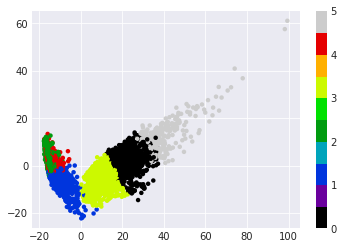

In [100]:
# Ваш код здесь

plt.scatter(
    X_reduced[:,0], X_reduced[:,1], 
    c=cluster_labels, s=20,  label=cluster_labels, edgecolor='none', 
    cmap=plt.cm.get_cmap('nipy_spectral', 10),
);
plt.colorbar();

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [101]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,742,0,0,903,0,77,1722
подъем вверх по лестнице,295,2,0,1242,0,5,1544
спуск по лестнице,889,0,0,321,0,196,1406
сидение,0,451,91,1,1234,0,1777
стояние,0,566,0,0,1340,0,1906
лежание,0,330,1556,5,53,0,1944
все,1926,1349,1647,2472,2627,278,10299


In [112]:
1242/1544  # подъем вверх по лестнице;   !!! TODO над как то решить это не в ручную)

0.8044041450777202

In [110]:
1234/1777

0.6944288126055149

In [111]:
1556/1944  # лежание

0.8004115226337448

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- нет верного ответа

### Ответ: нет верного ответа =(

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [113]:
def wgss(data, groups):
    '''Within groups sum of squares (wgss)
#     Сумма квадратов расстояний от центроида до каждой точки данных 
#     в многомерном пространстве.
#     Специально на английском, чтобы объяснить название функции 

http://easydan.com/arts/2016/hierarchy-clustering/
    '''
    _data = np.array(data)
    res = 0.0
    for cluster in groups:
        inclust = _data[np.array(groups) == cluster]
        meanval = np.mean(inclust, axis=0)
        res += np.sum((inclust - meanval) ** 2)
    return res

In [130]:
kmeans_k = KMeans(n_init=100, n_clusters=1, random_state=RANDOM_STATE).fit(X_pca)

kmeans.fit_predict

In [138]:
# # Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes+1)):
    predicted_group = KMeans(n_clusters=k, random_state=RANDOM_STATE).fit_predict(X_pca)
    print('feated kmeans', k)
    evaluate = wgss(X_pca, predicted_group)
    print(evaluate)
    inertia.append((k, evaluate))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

feated kmeans 1
53541589816.2682
feated kmeans 2
13451061898.485073
feated kmeans 3
8263330846.899626
feated kmeans 4
5399608304.302956
feated kmeans 5
4518122275.434794
feated kmeans 6
3615757434.274554



In [139]:
min(inertia, key=lambda value: value[1])

(6, 3615757434.274554)

In [124]:
# _X = X_scaled[:100]
# predicted_group = kmeans_k.predict(_X)
# wgss(_X, predicted_group)

288527.8927786718

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

### Ответ: 4   - переход в расстояниях становиться меньше

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [141]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

In [148]:
ag_predicted = ag.labels_

In [143]:
km_predicted = KMeans(n_init=100, n_clusters=len(np.unique(y)), random_state=RANDOM_STATE).fit_predict(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [149]:
metrics.adjusted_rand_score(y, ag_predicted)

0.4880109976849711

In [150]:
metrics.adjusted_rand_score(y, km_predicted)

0.4196778456687551

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

### Вопрос 6: Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), примените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [156]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [159]:
# Ваш код здесь
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [190]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(svc, svc_params, cv=3, verbose=1)

In [191]:
# Ваш код здесь
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   43.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [192]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.1}, 0.9382480957562568)

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

### Ответ 7: 0.1

In [177]:
y_predicted = grid_search.predict(X_test_scaled)

In [178]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


In [179]:
459/471

0.9745222929936306

In [180]:
413/420

0.9833333333333333

In [181]:
517/532

0.9718045112781954

In [183]:
426/491

0.8676171079429735

In [182]:
526/537

0.9795158286778398

**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – стояние, по полноте – сидение 

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


In [184]:
pca = PCA(n_components=count_components, random_state=RANDOM_STATE)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)

In [187]:
grid_search_pca = GridSearchCV(svc, svc_params, cv=3, verbose=1)
grid_search_pca.fit(X_pca_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   12.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [193]:
grid_search_pca.best_score_, grid_search.best_score_

(0.8983949945593036, 0.9382480957562568)

In [195]:
round(grid_search.best_score_ - grid_search_pca.best_score_, 2)

0.04

### Ответ 9: 4%

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

### Ответ 10: 1, 3